### Importing the needed libraries

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import BatchNormalization, add, Activation, UpSampling2D, multiply  

import tensorflow as tf

# Set some parameters
BATCH_SIZE = 16 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

###  1. Preparing the data

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


/var/folders/mh/v3x6dz8534gcdj91_hh0bdph0000gn/T/ipykernel_13528/477856969.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/670 [00:00<?, ?it/s]/var/folders/mh/v3x6dz8534gcdj91_hh0bdph0000gn/T/ipykernel_13528/477856969.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 57.07it/s]

Done!


###  2. Data Augmentation

In [4]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

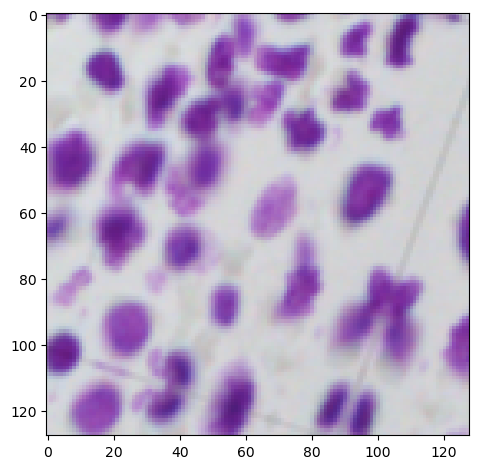

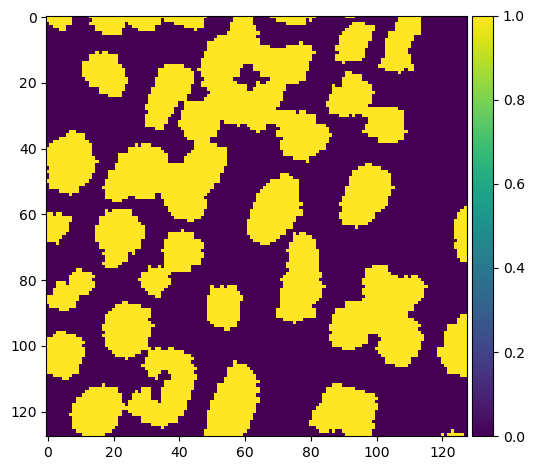

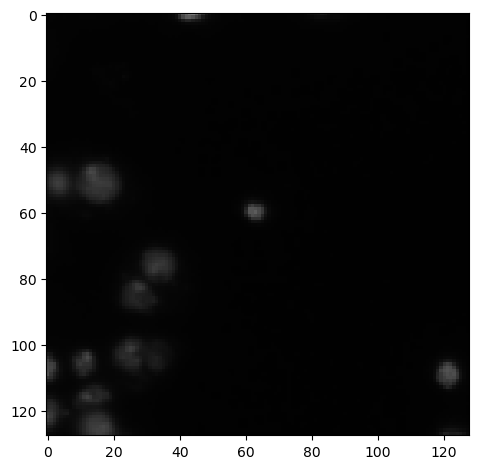

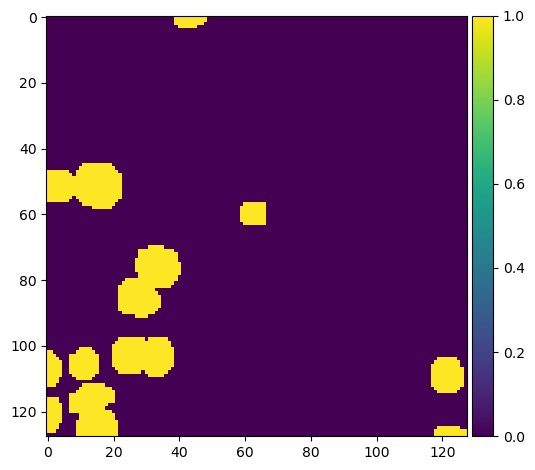

In [5]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

###  3. Creating the U-net model

In [6]:
train_generator = zip(x,y)
val_generator = zip(x_val, y_val)

In [7]:
# Define IoU metric
def jacard_coef(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0)/(K.sum(y_true_f)+K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [8]:
def res_conv_block(x,filter_size, size, dropout, batch_norm=False):
    '''
    Residual conv layer
    2 options:
        1. activation function before the addition with shortcut
        2. after the addition(which would be as proposed in the original resnet)
    '''
    conv = Conv2D(size, (filter_size,filter_size), kernel_initializer='he_normal', padding="same")(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation("elu")(conv)
    
    conv = Conv2D(size, (filter_size,filter_size), kernel_initializer='he_normal', padding="same")(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    #conv = Activation("relu")(conv)       #Activation before addtion with shortcut

    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size,kernel_size = (1,1), kernel_initializer='he_normal',padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)
    
    res_path =add([shortcut, conv])
    res_path = Activation('elu')(res_path)    #Activation after addtion with shortcut
    return res_path

def repeat_elem(tensor, rep):

    return Lambda(lambda x, repnum : K.repeat_elements(x,repnum,axis=3),arguments={'repnum':rep})(tensor)

def gating_signal(input,out_size,batch_norm=False):
    x = Conv2D(out_size,(1,1), activation='elu', kernel_initializer='he_normal', padding='same')(input)
    if batch_norm is True:
        x = BatchNormalization()(x)
    return x

def attention_block(x,gating,inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    #Getting x to the same shape as the gating signal
    theta_x = Conv2D(inter_shape,(2,2),kernel_initializer='he_normal',strides=(2,2),padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    #getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(inter_shape,(1,1),kernel_initializer='he_normal',padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape,(3,3),strides=(shape_theta_x[1] // shape_g[1],shape_theta_x[2]//shape_g[2]), padding='same')(phi_g)

    concat_xg = add([upsample_g,theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1,(1,1),padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],shape_x[2]//shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = repeat_elem(upsample_psi,shape_x[3])


    y = multiply([upsample_psi,x])

    result = Conv2D(shape_x[3],(1,1),padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

In [9]:
# Build Att-U-Net model
NUM_CLASSES = 1 
dropout_rate=0.1 
batch_norm=True
FILTER_NUM = 64
FILTER_SIZE = 3
UP_SAMP_SIZE = 2

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs = Lambda(lambda x: x / 255) (inputs)

#Downsampling layers
#DownRes 1, convolution +pooling
conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate,batch_norm)
pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
#DownRes 2
conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate,batch_norm)
pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
#DownRes 3
conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
#DownRes 4
conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)
#DownRes 5
conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

#Upsampling Layers
#UpRes 6
gating_16 = gating_signal(conv_8,8*FILTER_NUM, batch_norm)
att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
up_16 = UpSampling2D(size=(UP_SAMP_SIZE,UP_SAMP_SIZE), data_format='channels_last')(conv_8)
up_16 = concatenate([up_16,att_16], axis=3)
up_conv_16 = res_conv_block(up_16,FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

#UpRes 7
gating_32 = gating_signal(up_conv_16,4*FILTER_NUM, batch_norm)
att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
up_32 = UpSampling2D(size=(UP_SAMP_SIZE,UP_SAMP_SIZE), data_format='channels_last')(up_conv_16)
up_32 = concatenate([up_32,att_32], axis=3)
up_conv_32 = res_conv_block(up_32,FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

#UpRes 8
gating_64 = gating_signal(up_conv_32,2*FILTER_NUM, batch_norm)
att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
up_64 = UpSampling2D(size=(UP_SAMP_SIZE,UP_SAMP_SIZE), data_format='channels_last')(up_conv_32)
up_64 = concatenate([up_64,att_64], axis=3)
up_conv_64 = res_conv_block(up_64,FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

#UpRes 9
gating_128 = gating_signal(up_conv_64,FILTER_NUM, batch_norm)
att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
up_128 = UpSampling2D(size=(UP_SAMP_SIZE,UP_SAMP_SIZE), data_format='channels_last')(up_conv_64)
up_128 = concatenate([up_128,att_128], axis=3)
up_conv_128 = res_conv_block(up_128,FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

#1*1 convolutional layers
conv_final= Conv2D(NUM_CLASSES,kernel_size=(1,1))(up_conv_128)
conv_final = BatchNormalization(axis=3)(conv_final)
outputs = Activation('sigmoid')(conv_final) #change to softmax for multichannel

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',jacard_coef])
model.summary()

2022-10-27 22:53:24.461429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 22:53:24.461825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[1][0]']                 
 alization)       

###  4. Training

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('Attention_resunet.h5', verbose=1, save_best_only=True)
results = model.fit(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=1000, callbacks=[earlystopper, checkpointer],verbose=1,batch_size=BATCH_SIZE,shuffle=False)

2022-10-27 22:53:26.349248: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-27 22:53:28.891697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


151/250 [=================>............] - ETA: 4:44 - loss: 0.4294 - accuracy: 0.8617 - jacard_coef: 0.3679

KeyboardInterrupt: 

###  5. Prediction

In [ ]:
# Predict on train, val and test
model = load_model('Attention_resunet.h5', custom_objects={'jacard_coef': jacard_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))